Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Data Drift Detection
* Concept Drift: The drift in target
* Covariate Drift: The drift in feature(s)


* Population Stability Index (PSI) 
  * Used to compare 2 numerical distributions
  * Interpretation
    * PSI < 0.1: no significant population change
    * PSI < 0.2: moderate population change
    * PSI >= 0.2: significant population change
  * `psi.py` came from https://github.com/mwburke/population-stability-index/blob/master/psi.py

In [43]:
import pandas as pd
import numpy as np
from tqdm import tqdm
# tqdm._instances.clear()  # run this when tqdm shows multiple bars in your notebook
from matplotlib import pylab as plt
from matplotlib.offsetbox import AnchoredText

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score

from psi import calculate_psi
import seaborn as sns
sns.set(color_codes=True)

In [86]:
def plot_performance_lst(performance_lst, y_label, title):
    plt.figure(figsize=(15,7))
    ax = plt.gca()
    ax.set_ylim([0, 1.2]) # set y-axis range
    
    x = [i+1 for i in range(len(performance_lst))]
    y = performance_lst
    
    ax.plot(x, y, color='g')
    
    # anchor text to show text in the plot
    anchored_text = AnchoredText(f'Average {y_label} is {round(np.mean(performance_lst), 4)}', loc=3, prop={'size': 12})  # the location code: https://matplotlib.org/3.1.0/api/offsetbox_api.html
    ax.add_artist(anchored_text)  
    
    # annotate y_value along the line
    for i,j in zip(x,y):
        ax.annotate(str(round(j, 4)),xy=(i,j))  
    
    plt.xlabel('epoch #')
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


def compare_dist_plot(s1, s2, title, legend1, legend2, xlabel, saved_file):
    fig = plt.figure(figsize=(15,5))
    sns.kdeplot(s1, label=f'{legend1} distribution', color='green')
    sns.kdeplot(s2, label=f'{legend2} distribution', color='purple')
    plt.legend()
    plt.xlabel(f'{xlabel}')
    plt.ylabel('Density')
    
    psi = calculate_psi(s1, s2, buckettype='quantiles', buckets=100, axis=1)
    plt.title(f'{title} (PSI: {psi})', fontsize=18)
    
    plt.savefig(saved_file)
    
    
def check_model_data_drift(X, y, n_splits=10):
    # baseline performance through cross validation
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
    lgbm = lgb.LGBMClassifier(objective='binary', random_state=10, verbose=-1)
    metrics_lst = []

    for train_idx, val_idx in tqdm(folds.split(X, y), total=folds.get_n_splits()):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        lgbm.fit(X_train, y_train)
        y_pred = lgbm.predict(X_val)

        cv_balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        metrics_lst.append(cv_balanced_accuracy)

    plot_performance_lst(metrics_lst, 'balanced_accuracy', 'Baseline LightGBM Performance through Cross Validation')
    
    return lgbm

In [48]:
df = pd.read_pickle('../crystal_ball/data_collector/structured_data/sales.pkl')

# train, test split for df
train_df = df.loc[df['Year'].astype(str) < '2015']
test_df = df.loc[df['Year'].astype(str) == '2015']

y_train, y_test = train_df['Sales'], test_df['Sales']
X_train, X_test = train_df.drop(['Sales', 'Date', 'Year'], axis=1), test_df.drop(['Sales', 'Date', 'Year'], axis=1)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train.head()

(532529, 18) (161332, 18) (532529,) (161332,)


,Store,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,3,327,1,0,0,1
1,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,2,703,1,0,0,1
2,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,1,700,1,0,0,1
3,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,7,0,0,0,0,1
4,1,12,4,2,0,1270.0,9,2008,0,-1,-1,-1,6,684,1,0,0,1


### Un-drifted Data

#### Check Concept Drift

In [49]:
# label training data as 0 and label testing data as 1, put them together and shuffle
new_X_train = X_train.copy()
new_X_test = X_test.copy()

new_X_train['label'] = 0
new_X_test['label'] = 1

new_df = pd.concat([new_X_train, new_X_test])
new_df = new_df.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe
print(new_df.shape)
new_df.head()

(693861, 19)


,Store,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,label
0,1045,12,4,0,2,26990.0,12,2013,0,-1,-1,-1,5,1185,1,1,0,0,0
1,936,9,3,0,0,580.0,2,2008,0,-1,-1,-1,6,770,1,0,0,0,0
2,326,5,2,3,0,10070.0,5,2015,1,31,2013,"Feb,May,Aug,Nov",3,319,1,0,0,0,0
3,834,4,2,0,0,3470.0,3,2012,0,-1,-1,-1,4,916,1,1,0,0,1
4,627,4,2,2,2,3970.0,3,2010,0,-1,-1,-1,3,542,1,0,0,0,0


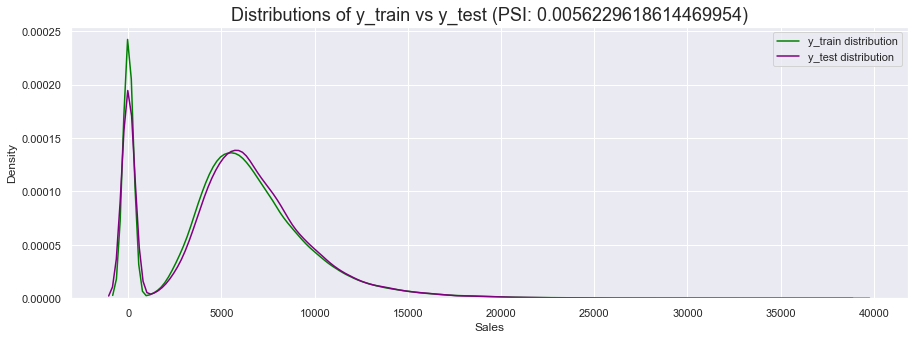

In [75]:
compare_dist_plot(y_train, y_test, title='Distributions of y_train vs y_test', 
                  legend1='y_train', legend2='y_test', xlabel='Sales',
                  saved_file='target_dist_comparision1.png')

#### Check Covariate Drift

* Training data with label 0 and testing data with label 1
* It's trying to classify 0 and 1, if the average accuracy is no more than 0.53, then we can say there is almost no covariate drift. Because we can't distinguish the training and the testing data

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.60s/it]


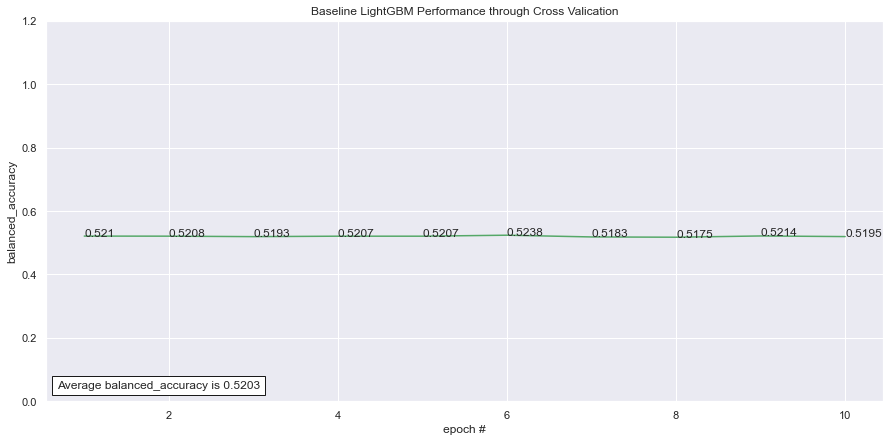

In [87]:
y = new_df['label']
X = new_df.drop('label', axis=1)
trained_model = check_model_data_drift(X, y, n_splits=10)

### Drifted Data

#### Check Concept Drift
* Create mockup drifting in the target value

In [72]:
drifted_y_test = y_test * 10

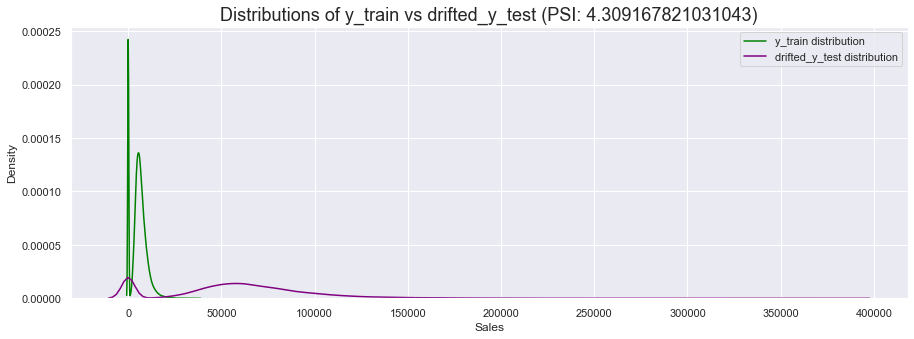

In [76]:
compare_dist_plot(y_train, drifted_y_test, title='Distributions of y_train vs drifted_y_test', 
                  legend1='y_train', legend2='drifted_y_test', xlabel='Sales',
                  saved_file='target_dist_comparision2.png')

#### Check Covariate Drift

* Create some mockup data drifting in important features

In [78]:
drifted_X_test = X_test.copy()
drifted_X_test['label'] = 1

# reverse some important features as mockup data drifting
drifted_X_test['Store'] = drifted_X_test['Store'][::-1].values

drifted_df =pd.concat([new_X_train, drifted_X_test])
drifted_df = drifted_df.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe
print(drifted_df.shape)
drifted_df.head()

(693861, 19)


,Store,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Customers,Open,Promo,StateHoliday,SchoolHoliday,label
0,779,12,4,0,0,16990.0,4,2004,0,-1,-1,-1,6,482,1,0,0,0,0
1,569,4,2,0,0,1340.0,9,2006,0,-1,-1,-1,3,668,1,1,0,0,0
2,525,9,3,3,2,1870.0,9,2013,0,-1,-1,-1,1,896,1,0,0,0,0
3,621,7,3,0,0,30.0,7,2002,0,-1,-1,-1,7,0,0,0,0,0,0
4,831,12,4,0,0,800.0,6,2007,0,-1,-1,-1,7,0,0,0,0,0,0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


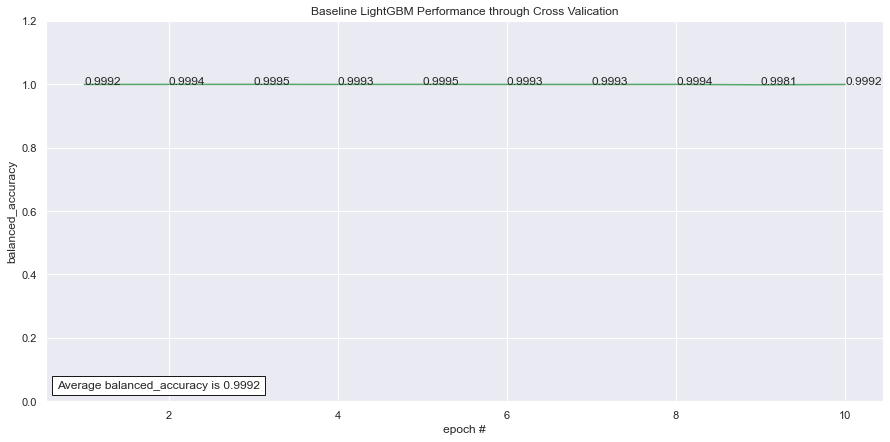

In [79]:
drifted_y = drifted_df['label']
drifted_X = drifted_df.drop('label', axis=1)
trained_model = check_model_data_drift(drifted_X, drifted_y, n_splits=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

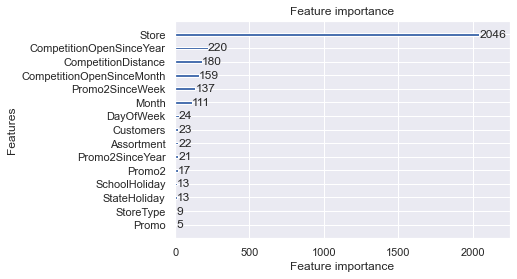

In [80]:
lgb.plot_importance(trained_model)